# Implementation of Quantum Kernel to learn the phases of Quantum Matter

Eleonora Lamma, Youssef Makoudi, Luca Paradiso

The aim of this project is to classify the phases of a Ising chain in transverse field and estimating the value of the critical point

Contents
- dataset creation
- noise model creation
- training with SVM

#### Introduction

We consider the one dimensional quantum Ising model in a transverse field with Hamiltonian with PBC
\begin{equation}
H(J) = \sum_{i=1}^N \sigma^z_i - J \sum_{i=1}^N \sigma^x_i\sigma^x_{i+1}
\end{equation}
This Ising model shows a second order phase transition at $J_c=1$ when $N\to\infty$ where $N$ is the number of the sites in the Ising chain.

The basic idea behind this work is creating a dataset with the ground states of this Hamiltonian as $J$ varies in the interval $[0.25,1.75]$ and then using them to train a support vector machine.
The ground states are built through the variational principle implemented with the help of a variational quantum eigensolver. Parameters that return the estimated ground state through an ansatz circuit are saved and used for the training.

The kernel used in the support vector machine is defined as the fidelity between two ground states
$$ K(J_i,J_j) = |\langle \psi_0(J_i)|\psi_0(J_j)\rangle $$

The critical point is defined as the $J$ that has zero distance from the hyperplane found by the support vector machine.

#### Dataset creation

In [1]:
# importing the necessary libraries

#qsvm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import EfficientSU2
from qiskit import Aer
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import X,Z,I
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info.operators import Operator
from sklearn import svm
from qiskit.tools.visualization import plot_histogram, plot_error_map
from qiskit.quantum_info import average_gate_fidelity


#noise
from qiskit.providers.fake_provider import FakeToronto
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import depolarizing_error

In [2]:
# defintion of preliminary variables

optimizer = COBYLA(tol=0.01)
intermediate_info = dict()

backend = AerSimulator(method='statevector')
quantum_instance = QuantumInstance(backend=backend, seed_transpiler=1)

reps = 1        # number of blocks repeatition in the ansatz circuit

In [3]:
# definition of necessary functions

def Hamiltonian(N, J):
    """ 
    given N number of sites in the Ising Chain and J as above.
    Returns the Hamiltonian as sum of Pauli Operators
    """
    
    H = -J*(X^(I^N-2)^X) + (I^(N-1)^Z)
    for i in range (N-1):
        H += -J*((I^i)^(X^X)^(I^(N-2-i))) + ((I^i)^(Z)^(I^(N-i-1)))
    return H

def callback(nfev, parameters, energy, stddev):
    """ 
    function that saves all variables generated during the VQE
    """
    
    intermediate_info['parameters'] = parameters
    intermediate_info['nfev'] = nfev
    intermediate_info['energy'] = energy

    return None

def GS(N,J):
    """ 
    given N and J estimates parameters 
    needed by the ansatz circuit to give the Ground state 
    """
    
    H = Hamiltonian(N,J)
    ansatz = EfficientSU2(N, su2_gates=['ry'], reps=reps, entanglement='linear', insert_barriers=True)
    np.random.seed(80)
    initial_point = np.random.random(N*(reps+1))
    local_vqe = VQE(ansatz=ansatz,
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=quantum_instance,
                    callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H)
    par = intermediate_info['parameters']
    
    return par, local_result.eigenvalue

In [4]:
# example of ANSATZ CIRCUIT used
N=4
ansatz = EfficientSU2(N, su2_gates=['ry'], reps=reps, entanglement='linear', insert_barriers=True)
ansatz.decompose().draw()

┌──────────┐ ░                 ░ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├─░───■─────────────░─┤ Ry(θ[4]) ├
     ├──────────┤ ░ ┌─┴─┐           ░ ├──────────┤
q_1: ┤ Ry(θ[1]) ├─░─┤ X ├──■────────░─┤ Ry(θ[5]) ├
     ├──────────┤ ░ └───┘┌─┴─┐      ░ ├──────────┤
q_2: ┤ Ry(θ[2]) ├─░──────┤ X ├──■───░─┤ Ry(θ[6]) ├
     ├──────────┤ ░      └───┘┌─┴─┐ ░ ├──────────┤
q_3: ┤ Ry(θ[3]) ├─░───────────┤ X ├─░─┤ Ry(θ[7]) ├
     └──────────┘ ░           └───┘ ░ └──────────┘

The use of Ry gates with just one block of linear entranglement of CNOT gates is empirically the best ansatz, as far as we know. Repeating the blocks more times does not increase the accuracy and can be counterproductive from computational resources point of view.
By the way recalling that 
\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}RY(\theta) = \exp\left(-i \th Y\right) =
    \begin{pmatrix}
        \cos{\th} & -\sin{\th} \\
        \sin{\th} & \cos{\th}
    \end{pmatrix}\end{split}\end{aligned}\end{align}
    
We can see that this is the best gate to explore all the Hilbert space without considering the phase of the components, although some reduction of the explorable space can be made based on the symmetries of the ground state.

In [5]:
# now we can define N and the interval for J we prefer
# for example we take N=6 and 50 points equally spaced

N = 6
Js = np.linspace(0.25,1.75,50)

In [6]:
f = open(f'dataset_{N}.txt','w')
for J in Js:
    par, E = GS(N,J)
    f.write(str(round(J,4))+', ')
    f.write(str(round(E.real,4))+', ')
    for j in range(len(par)):
        f.write(str(round(par[j],4))+', ')
    f.write('\n')
f.close()
print(f'Finished dataset for {N}')

Finished dataset for 6


## Noise model creation


In this section Qiskit Aer is used to create a basic noise model to be applied to a certain device, starting from some properties associated with it and obtained through the backend.properties() function

From https://qiskit.org/documentation/apidoc/providers_fake_provider.html the ibmq_Toronto device is chosen, to simulate the behavior of circuits up to 27 qubits.

In [7]:
from qiskit.providers.fake_provider import FakeToronto
backend = FakeToronto()
sim_toronto = AerSimulator.from_backend(backend)

The chosen backend is displayed with associated errors:

In [ ]:
plot_error_map(backend)

The next step is to give a list of possible qubits to work on based on the errors associated with each of them, which are shown on the map. Creating this noise model actually requires working with adjacent qubits, which automatically rules out 9, 20, 26, 17, 6.

In [8]:
qubits_layout_tot = [0,1,2,3,5,8,11,14,16,19,22,25,24,23,21,18,15,12,10,7,4]

In [9]:
qubits_layout = qubits_layout_tot[0:N]
print(qubits_layout)

[0, 1, 2, 3, 5, 8]


Qiskit Aer generates a simplified noise model that includes three main types of errors:

1. single-qubit gate errors = a single-qubit depolarizing error followed by a single-qubit thermal relaxation error
2. two-qubit gate errors = a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits associated with the gate
3. single qubit readout errors on the classic bit value, deriving from measurements on single qubits.

In the following code we choose to create a separate model for each type, in order to study the effect of the respective errors on the circuits used to build the kernel, and therefore on the determination of the critical J.

Altogether these simulations are performed:

- noiseless --> l=0
- single-qubit error --> l=1
- readout error --> l=2
- two-qubit error --> l=3
- all three types together --> l=4
- device error in its entirety --> l=5

The error models are applied after the transpiling operation, which rewrites the circuit using IBM's native gates, namely X, SX, CNOT, and Rz. With the exception of the last one, which is a virtual operation, these are the types of gates to which gate errors will be applied. The readout, on the other hand, is associated with the measurement operation.

In [10]:
nshots = 1024

In [11]:
def IBM_noise_model(N):
    
    noise_model_1 = NoiseModel()
    noise_model_2 = NoiseModel()
    noise_model_3 = NoiseModel()
    noise_model_4 = NoiseModel()
    
    prop = backend.properties()
    
    # For each basis gate, its duration and error probabilities are read from the properties of the
    # chosen backend and collected in arrays. Then they will be used to model the errors
    
    #Legend:----------------------------------------------------------------------------------------------------------
    
    # T1 = time taken for a qubit to go from the excited state |1> to the ground state |0>
    
    # T2 = decoherence time, i.e. the time required for the phase to no longer be accurately predicted
    
    # readout_error = error which flips the recorded value of the classic bit after the measurement
    
    # gate_error: returns an estimate of the error associated with the gate starting from the backend properties
    # See the note at the end of the section for more specifics
    
    # gate_length: returns the duration of the gate in seconds
    
    #--------------------------------------------------------------------------------------------------------------------------

    #--------------------------------------The needed parameters are collected------------------------------------------------
    
    # Based on various tests done, gate_length for x and sx turns out to be the same and equal for all qubits. 
    # Instead, gate_error is the same for x and sx if we consider the same qubit
    
    tg = prop.gate_length('x',qubits_layout[0]) 
    
    T1 = [prop.t1(j) for j in qubits_layout]
    T2 = [prop.t2(j) for j in qubits_layout]
    p = [prop.gate_error('x',[j]) for j in qubits_layout] 
    rout = [prop.readout_error(j) for j in qubits_layout]
    
    t_cnot = np.zeros((N,N))
    p_cnot = np.zeros((N,N))
    
    if (N > 1):
        for i in range(0,N):
            if (i == 0):
                t_cnot[0][1] = prop.gate_length('cx',[qubits_layout[0],qubits_layout[1]])
                p_cnot[0][1] = prop.gate_error('cx',[qubits_layout[0],qubits_layout[1]])
            if (i != 0 and i != N-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
                t_cnot[i][i+1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i+1]])
                p_cnot[i][i+1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i+1]])
            if (i == N-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
                
    
    #SINGLE QUBIT
    #--------------------------Computing the errors using the respective parameters---------------------------------------
        
    for j in range(0,N):
        
        #single qubit depolarizing
        dep_1 = depolarizing_error(p[j],1)
        
        #single qubit thermal relaxation
        thermal_relax = thermal_relaxation_error(T1[j], T2[j], tg)
        
        #readout error
        readout = pauli_error([('X',rout[j]), ('I', 1 - rout[j])])
        
        #----------------------Adding the errors to the corresponding noise models-----------------------------------------------
        
        single_qubit_gate_error = dep_1.compose(thermal_relax)
        
        noise_model_1.add_quantum_error(single_qubit_gate_error, ["x","sx"],[qubits_layout[j]])
        noise_model_4.add_quantum_error(single_qubit_gate_error, ["x","sx"],[qubits_layout[j]])
        
        noise_model_2.add_quantum_error(readout, "measure",[qubits_layout[j]])
        noise_model_4.add_quantum_error(readout, "measure",[qubits_layout[j]])
        
        
#TWO QUBITS
#------------------------------------------------------------------------------------------------------------------------------
    for j in range(0,N):
        for k in range(0,N):
            if (k == j+1 or k == j-1):
                
                #two qubits relaxation
                thermal_relax_j = thermal_relaxation_error(T1[j], T2[j], t_cnot[j][k])
                thermal_relax_k = thermal_relaxation_error(T1[k], T2[k], t_cnot[j][k])
                thermal_relax_jk = thermal_relax_k.tensor(thermal_relax_j)
   
                #two qubits depolarizing
                dep_2 = depolarizing_error(p_cnot[j][k],2)
                
                
                #-------adding the errora to the noise models---------------------------------------------------------------------
                
                two_qubits_gate_error = dep_2.compose(thermal_relax_jk)
                
                noise_model_3.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
                noise_model_4.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
    
        noise_models = [noise_model_1, noise_model_2, noise_model_3, noise_model_4]
    return noise_models


In [12]:
# saving different noise models in a list

noise_models = IBM_noise_model(N)

NM = {'0':'noiseless',
      '1':'noise 1',
      '2':'noise 2',
      '3':'noise 3',
      '4':'noise 4',
      '5':'device'}

#### Note

As mentioned at the beginning of the section, and as explained in the qiskit documentation (https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/simulators/2_device_noise_simulation.ipynb), single qubit gate errors are made of a single qubit depolarizing error + a single qubit thermal relaxation error. Also from the documentation, "The probability of the depolarizing error is [...] set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the gate_error value from the backend properties". This information is needed to correctly choose the probability associated with the depolarizing error.

However, in calculating the average gate infidelity associated with the thermalization error for each qubit of the layout, it turns out that this is almost always greater than the gate_error, thus contradicting what is reported in the documentation:

In [13]:
prop = backend.properties()

T1 = [prop.t1(j) for j in qubits_layout_tot]
T2 = [prop.t2(j) for j in qubits_layout_tot]
p = [prop.gate_error('x',[j]) for j in qubits_layout_tot]
tg = prop.gate_length('x',qubits_layout[0]) 
    

for j in range(0, len(qubits_layout_tot)):
    
    thermal_relax = thermal_relaxation_error(T1[j], T2[j], tg)
    
    average_gate_infidelity = 1 - average_gate_fidelity(thermal_relax)
    
    if (average_gate_infidelity>p[j]):
        print('average gate infidelity > gate error, qbuit ',qubits_layout_tot[j])
        
    else:
        print('ok, qubit ', qubits_layout_tot[j])

average gate infidelity > gate error, qbuit  0
average gate infidelity > gate error, qbuit  1
average gate infidelity > gate error, qbuit  2
average gate infidelity > gate error, qbuit  3
average gate infidelity > gate error, qbuit  5
average gate infidelity > gate error, qbuit  8
average gate infidelity > gate error, qbuit  11
average gate infidelity > gate error, qbuit  14
ok, qubit  16
average gate infidelity > gate error, qbuit  19
average gate infidelity > gate error, qbuit  22
average gate infidelity > gate error, qbuit  25
average gate infidelity > gate error, qbuit  24
average gate infidelity > gate error, qbuit  23
average gate infidelity > gate error, qbuit  21
average gate infidelity > gate error, qbuit  18
average gate infidelity > gate error, qbuit  15
ok, qubit  12
average gate infidelity > gate error, qbuit  10
average gate infidelity > gate error, qbuit  7
average gate infidelity > gate error, qbuit  4


In the case of two-qubit errors this happens every time:

In [14]:
t_cnot = np.zeros((len(qubits_layout_tot),len(qubits_layout_tot)))
p_cnot = np.zeros((len(qubits_layout_tot),len(qubits_layout_tot)))

for i in range(0,len(qubits_layout_tot)):
    if (i == 0):
        t_cnot[0][1] = prop.gate_length('cx',[qubits_layout_tot[0],qubits_layout_tot[1]])
        p_cnot[0][1] = prop.gate_error('cx',[qubits_layout_tot[0],qubits_layout_tot[1]])
    if (i != 0 and i != len(qubits_layout_tot)-1):
        t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout_tot[i],qubits_layout_tot[i-1]])
        p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout_tot[i],qubits_layout_tot[i-1]])
        t_cnot[i][i+1] = prop.gate_length('cx',[qubits_layout_tot[i],qubits_layout_tot[i+1]])
        p_cnot[i][i+1] = prop.gate_error('cx',[qubits_layout_tot[i],qubits_layout_tot[i+1]])
    if (i == len(qubits_layout_tot)-1):
        t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout_tot[i],qubits_layout_tot[i-1]])
        p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout_tot[i],qubits_layout_tot[i-1]])

for j in range(0,len(qubits_layout_tot)):
        for k in range(0,len(qubits_layout_tot)):
            if (k == j+1 or k == j-1):
                
                #two qubits relaxation
                thermal_relax_j = thermal_relaxation_error(T1[j], T2[j], t_cnot[j][k])
                thermal_relax_k = thermal_relaxation_error(T1[k], T2[k], t_cnot[j][k])
                thermal_relax_jk = thermal_relax_k.tensor(thermal_relax_j)

                average_gate_infidelity = 1 - average_gate_fidelity(thermal_relax_jk)
                
                if (average_gate_infidelity<p[j]):
                    
                    print('ok')

This same issue is also reported here: https://github.com/Qiskit/qiskit-aer/issues/1655. Unlike the proposal reported in the post, in the noise models built here it is preferred to keep the thermalization error built with the parameters T1 and T2 given by the backend, and to understand gate_error as the probability associated with the depolarizing error.

This anomaly is basically the reason why both the simulation l=4 and l=5 are performed: they are not equivalent.

#### Training

For the training we need to implement the Kernel as written above.
We will follow the 1st algorithm presented in the paper on which the work is based

In [21]:
def circuit(N):
    """
    Define the circuit for the Quantum Kernel
    """

    qr = QuantumRegister(N)
    qc = QuantumCircuit(qr)
    GS1 = EfficientSU2(N, su2_gates=['ry'], reps=reps, entanglement='linear', insert_barriers=True, parameter_prefix='p1')
    GS2 = EfficientSU2(N, su2_gates=['ry'], reps=reps, entanglement='linear', insert_barriers=True, parameter_prefix='p2')
    
    qc.append(GS1, qr)
    qc.append(GS2.inverse(), qr)
    qc.measure_all(add_bits=True)

    return qc


def bind_circuit(c, pi, pj, l):
    """
    bind the parameters to the circuit defined for the Quantum Kernel
    and choose the noise model to use
    l=0 -> noiseless
    l=1,2,3,4 -> models with noise respectively 1,2,3 tipo e 4 tutti insieme
    l=5 -> simulation on device
    """
    
    #p_{i} parameters from the GS_{i} and p_{j} parameters from the GS_{j}
    p = np.append(pi, pj)
    bind_dict = {c.parameters[i]: p[i] for i in range(c.num_parameters)}
    c = c.bind_parameters(bind_dict)
    
    #senza noise
    if l == 0:
        tqc = transpile(c, backend, initial_layout = qubits_layout, seed_transpiler=5)
        sim_noiseless_1 = AerSimulator(method='statevector') 
        result_1 = sim_noiseless_1.run(tqc, shots=nshots).result()
        counts = result_1.get_counts()
    
    #con noise model
    elif l == 1 or l == 2 or l==3 or l==4:
        tqc = transpile(c, backend, initial_layout = qubits_layout, seed_transpiler=5)
        sim_noise_1 = AerSimulator(noise_model=noise_models[l-1], method='statevector')  
        result_1 = sim_noise_1.run(tqc, shots=nshots).result()
        counts = result_1.get_counts()
    
    #su device
    elif l==5:
        tqc = transpile(c, sim_toronto, initial_layout = qubits_layout, seed_transpiler=5)
        result_1 = sim_toronto.run(tqc, shots=nshots).result()
        counts = result_1.get_counts()
        
    return counts


def QKernel(p1, p2, l):
    """
    Quantum Kernel algorithm using Fidelity.
    Takes two sets of array of parameters and the noise/device chosen
    """
    
    print(f'chiamata del kernel con {NM[str(l)]}')
    
    c = circuit(N)
    x = len(p1)
    y = len(p2)
    K = np.empty((x, y), dtype=np.float64, order='C')
    
    for i in range(x):
        
        for j in range(i,y):
            
            counts = bind_circuit(c, p1[i], p2[j], l)
            if i == j:
                K[i,j] = 1
            else:
                try:
                    K[i, j] = counts[N*'0'] / nshots
                    K[j, i] = counts[N*'0'] / nshots
                except KeyError:
                    #if counts[N*'0'] is zero, then the relative Key (N*'0') isn't present in the dictionary (counts)
                    K[i, j] = 0.
                    K[j, i] = 0.
    K = np.sqrt(K)
    return K


def Qgram(p1, p2, l):
    """
    alculate Gram matrix as it is done in the kernel
    it is used to calculate the distance from the hyperplane
    take two sets of array of parameters and the noise/device chosen
    """
    
    c = circuit(N)
    y = len(p2)
    G = np.empty(shape=y, dtype=np.float64, order='C')
   
    for i in range(y):
        counts = bind_circuit(c, p1, p2[i], l)
        try:
            G[i] = counts[N*'0'] / nshots
        except KeyError:
            #if counts[N*'0'] is zero, then the relative Key (N*'0') isn't present in the dictionary (counts)
            G[i] = 0.
    
    G = np.sqrt(G)
    G = G.reshape(1, -1)
    return G


def Qdistance(J, l):
    """
    Distance function using the decision_function method from sklearn
    """

    p, E = GS(N, J)
    G = Qgram(p, p_train, l)
    d = clf.decision_function(G)

    return float(d)


def Qdistance_vet(p, l):
    """
    Distance function using the method decision_function of sklearn
    """

    p = p.reshape(1, -1)
    G = Qgram(p, p_train, l)
    d = clf.decision_function(G)

    return float(d)


def J_critical(l):
    """
    Minimize the distance function in order to find Jc
    """

    results = root_scalar(Qdistance, args=l, bracket=(sv_J[0], sv_J[-1]))

    if not results.converged:
        raise Exception(results.flag)
    else:
        return results.root

In [35]:
# defining some save and plot functions that will be usefull later

def plot_Kmatrix(K):
    """
    Plot the Kernel
    """

    fig = plt.figure(layout='constrained')
    ax = fig.add_subplot()
    cax = ax.matshow(K, cmap=plt.cm.get_cmap('cividis', ), interpolation='nearest')
    fig.colorbar(cax)

    ax.set_title('Kernel', size=20)
    plt.savefig(f'K{N}_{l}.pdf', bbox_inches='tight')


def save_SV():
    """
    save the Support Vectors
    """

    file = open(f'support_vector{N}_{l}.txt','w')
    for i in range(M):
        file.write(str(sv_J[i]) + ', ')
        sv_d = Qdistance_vet(sv[i], l)
        file.write(str(round(sv_d, 4)) + '\n')
    file.close()
    

def save_dVSJ():
    """
    save dVSJN.txt file. 
    DeltaJ = [0.25, 1.75] according to the paper
    """

    DeltaJ = Js
    par = Ps
    f = open(f'distVSJ{N}_{l}.txt','w')
    f.write(f'#Format: J VS d in columns, {2*len(DeltaJ)} data. \n')

    for i in range(len(DeltaJ)):
        dJ = Qdistance_vet(par[i], l)
        f.write(str(DeltaJ[i]) + ', ')
        f.write(str(round(dJ, 4)) + '\n')

    f.close()


def HarryPlotter_dvsJ():
    """
    Plot distance VS J
    """

    a = np.genfromtxt(f'distVSJ{N}_{l}.txt', delimiter=',')
    a2 = np.genfromtxt(f'support_vector{N}_{l}.txt', delimiter=',')
    J = a[:, 0]
    d = a[:, 1]
    J_sv = a2[:, 0]
    d_sv = a2[:, 1]

    fig, ax = plt.subplots(figsize=(5,4), layout='constrained')

    ax.set_xlabel("J", size=15)
    ax.set_ylabel("distance", size=15)
    ax.set_title(f'd V.s. J for N = {N}')
    ax.text((Jc + 0.1), -0.2, r'$J_{c} =$' + str(round(Jc, 3)))

    ax.text(J_train[len(J_train)//2], 0.1, r'$\delta J_{1}$', c='dimgray', size=15)
    ax.text(J_train[0], 0.1, r'$\delta J_{2}$', c='dimgray', size=15)
    ax.axvspan(J_train[0], J_train[len(J_train)//2-1], alpha=0.5, color='gainsboro')
    ax.axvspan(J_train[len(J_train)//2], J_train[len(J_train)-1], alpha=0.5, color='lightgrey')

    ax.plot(J, d, c='midnightblue', label=f'd N={N}')
    ax.plot(J, np.zeros(len(J)), c='dimgray', linestyle=':')
    #ax.scatter(np.round(sv_J,1), np.round(d_sv, 1), facecolor='None', edgecolor='midnightblue', s=40, label=f'SV N={N}')
    plt.legend()
    plt.savefig(f'results/noiseless/dVSJ{N}.pdf', bbox_inches='tight')

In [24]:
dataset = np.genfromtxt('dataset_6.txt', delimiter=',')
Js = dataset[:, 0]
Ps = dataset[:, 2:-1]
Ys = [1 if x > 1 else -1 for x in Js]

# select a sub-interval from dataset_6, for the training of SVM
J_train = np.concatenate((Js[:10],Js[-10:]))
p_train = np.concatenate((Ps[:10],Ps[-10:]))
y_train = np.concatenate((Ys[:10],Ys[-10:]))


# we loop on the differente noise models to estimate Jc
for l in range(6):
    
    # calculate and save kernel
    K = QKernel(p_train, p_train, l)
    kfile = open(f'kernel{l}.npy','wb')
    np.save(kfile,K)
    kfile.close()
    
    # training with precomputed kernel
    clf = svm.SVC(kernel='precomputed', cache_size=1000)
    clf.fit(K, y_train)
    
    # save information about support vector
    sv = p_train[clf.support_]
    print(sv)
    sv_J = J_train[clf.support_]
    M  = len(sv)
    
    # calculate and save distance of support vectors
    save_SV()

    #find J Critical
    Jc = J_critical(l)
    print(Jc)
    
    # if there is need to see the trend of the distance in function of J
    # estimates and save the distance for each J
    save_dVSJ()

chiamata del kernel con noiseless
[[1.4242 1.3327 1.3423 1.3383 1.3317 1.3317 1.7191 1.6088 1.5754 1.5707
  1.563  1.5686]
 [1.5722 1.3097 1.2994 1.3074 1.3057 1.308  1.5504 1.5541 1.5569 1.5643
  1.5561 1.5534]
 [1.3081 1.5178 1.5172 1.5131 1.5158 1.5117 0.6204 0.3821 0.3634 0.3606
  0.3651 0.3478]
 [1.6326 1.514  1.5197 1.5169 1.5131 1.5204 0.2789 0.35   0.3475 0.3515
  0.3499 0.3412]]
0.778972675546553
chiamata del kernel con noise 1
[[1.4847 1.3459 1.3497 1.3474 1.3551 1.3564 1.6373 1.5755 1.5638 1.5629
  1.5597 1.559 ]
 [1.4242 1.3327 1.3423 1.3383 1.3317 1.3317 1.7191 1.6088 1.5754 1.5707
  1.563  1.5686]
 [1.5396 1.3204 1.3183 1.3168 1.323  1.3208 1.6088 1.5725 1.566  1.56
  1.5739 1.5721]
 [1.5722 1.3097 1.2994 1.3074 1.3057 1.308  1.5504 1.5541 1.5569 1.5643
  1.5561 1.5534]
 [1.3081 1.5178 1.5172 1.5131 1.5158 1.5117 0.6204 0.3821 0.3634 0.3606
  0.3651 0.3478]
 [1.2924 1.5155 1.5117 1.5064 1.5102 1.5123 0.6362 0.3688 0.3693 0.363
  0.3625 0.3491]
 [1.6326 1.514  1.5197 1.516

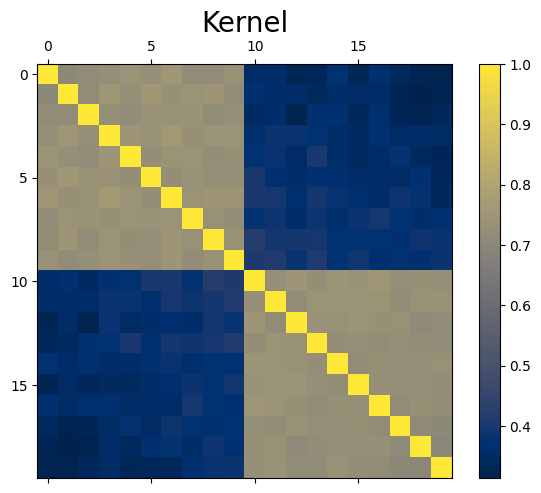

In [25]:
# plot of the kernel and distance, we take the last one computed in the previous cycle for, l=5
plot_Kmatrix(K)

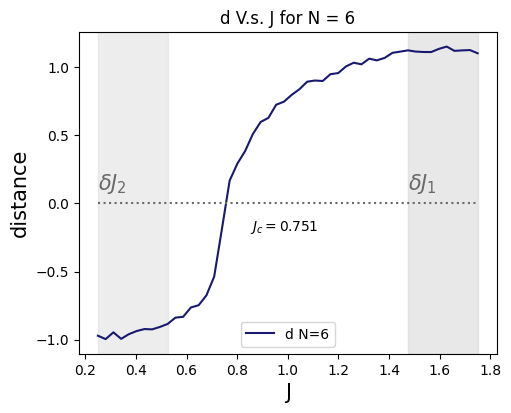

In [36]:
HarryPlotter_dvsJ()